# Linear Regression Residual Diagnostics & Interactive Exploration

This notebook demonstrates a full diagnostics workflow for linear regression:
1. Data loading & preparation
2. Model fitting
3. Residual computation & statistical summaries
4. Diagnostic plots (linearity, variance, normality, influence)
5. Statistical tests (normality, heteroskedasticity, autocorrelation, multicollinearity)
6. Interactive exploration & dynamic refitting
7. Export of diagnostic artifacts

> Goal: Provide a reproducible analytical pattern you can adapt to your own regression problems.

In [1]:
# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plot style
sns.set_theme(context='notebook', style='whitegrid')

DATA_DIR = Path('../data')
REPORT_DIR = Path('../reports')
REPORT_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
# 2. Load & Preview Data
# For demonstration we synthesize a regression dataset with controlled noise & slight heteroskedasticity
rng = np.random.default_rng(42)
N = 300
X1 = rng.uniform(0, 10, N)
X2 = rng.normal(5, 2, N)
# Introduce slight correlation and a non-linear component to challenge the model
noise = rng.normal(0, 1 + 0.15 * X1, N)  # variance increases with X1 (heteroskedastic)
Y = 3.5 + 2.2 * X1 - 0.9 * X2 + 0.15 * (X1**2) + noise  # quadratic term not modeled explicitly

df = pd.DataFrame({'feature_x1': X1, 'feature_x2': X2, 'target': Y})

print("Data Shape:", df.shape)
print(df.head())
print("\nDescribe:\n", df.describe().T)


Data Shape: (300, 3)
   feature_x1  feature_x2     target
0    7.739560    4.415658  26.046849
1    4.388784    4.793023  14.402561
2    8.585979    4.496045  26.603903
3    6.973680    5.305125  21.871858
4    0.941773    7.942984   0.634843

Describe:
             count       mean        std       min       25%        50%  \
feature_x1  300.0   4.866535   2.903062  0.073623  2.271564   4.790042   
feature_x2  300.0   4.969149   2.021077 -0.929058  3.604399   5.105496   
target      300.0  14.404790  10.853416 -3.190156  5.021378  13.372483   

                  75%        max  
feature_x1   7.509779   9.923756  
feature_x2   6.326792  10.195347  
target      23.492830  40.004510  


In [3]:
# 3. Feature Engineering & Train/Test Split
# (No categorical encoding needed here; demonstrate scaling)
X = df[['feature_x1', 'feature_x2']].copy()
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=123)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (225, 2) Test shape: (75, 2)


In [4]:
# 4. Fit Linear Regression Model (sklearn + statsmodels OLS)
lin_model = LinearRegression().fit(X_train, y_train)
train_pred = lin_model.predict(X_train)
test_pred = lin_model.predict(X_test)

print("Coefficients:", lin_model.coef_)
print("Intercept:", lin_model.intercept_)
print("Train R^2:", r2_score(y_train, train_pred))
print("Test R^2:", r2_score(y_test, test_pred))

# Statsmodels for extended diagnostics (adds intercept automatically if using add_constant)
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary().tables[0])


Coefficients: [10.31659145 -1.93705054]
Intercept: 14.424251025371445
Train R^2: 0.9703052379862767
Test R^2: 0.9560135264958773
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     3627.
Date:                Wed, 24 Sep 2025   Prob (F-statistic):          2.93e-170
Time:                        23:37:00   Log-Likelihood:                -452.77
No. Observations:                 225   AIC:                             911.5
Df Residuals:                     222   BIC:                             921.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         


In [5]:
# 5. Compute Predictions & Residuals DataFrame
train_resid = y_train - train_pred
test_resid = y_test - test_pred

residuals_df = pd.DataFrame({
    'fitted_train': train_pred,
    'resid_train': train_resid,
})
residuals_df.head()

,fitted_train,resid_train
107,6.496931,-1.746645
5,36.728237,-1.435975
207,19.397413,-0.531980
277,13.611126,0.435657
259,20.167652,0.635859


In [7]:
# 6. Residuals Summary Stats & Error Metrics
# Fallback for older sklearn versions lacking squared argument in mean_squared_error
try:
    rmse_train = mean_squared_error(y_train, train_pred, squared=False)
except TypeError:
    rmse_train = mean_squared_error(y_train, train_pred) ** 0.5

summary_stats = pd.Series({
    'mean': train_resid.mean(),
    'std': train_resid.std(),
    'skew': stats.skew(train_resid),
    'kurtosis': stats.kurtosis(train_resid, fisher=True),
    'RMSE_train': rmse_train,
    'MAE_train': mean_absolute_error(y_train, train_pred),
    'R2_train': r2_score(y_train, train_pred),
    'R2_test': r2_score(y_test, test_pred)
})
summary_stats

mean         -3.236917e-16
std           1.814154e+00
skew          3.942641e-02
kurtosis      6.121528e-01
RMSE_train    1.810118e+00
MAE_train     1.419201e+00
R2_train      9.703052e-01
R2_test       9.560135e-01
dtype: float64

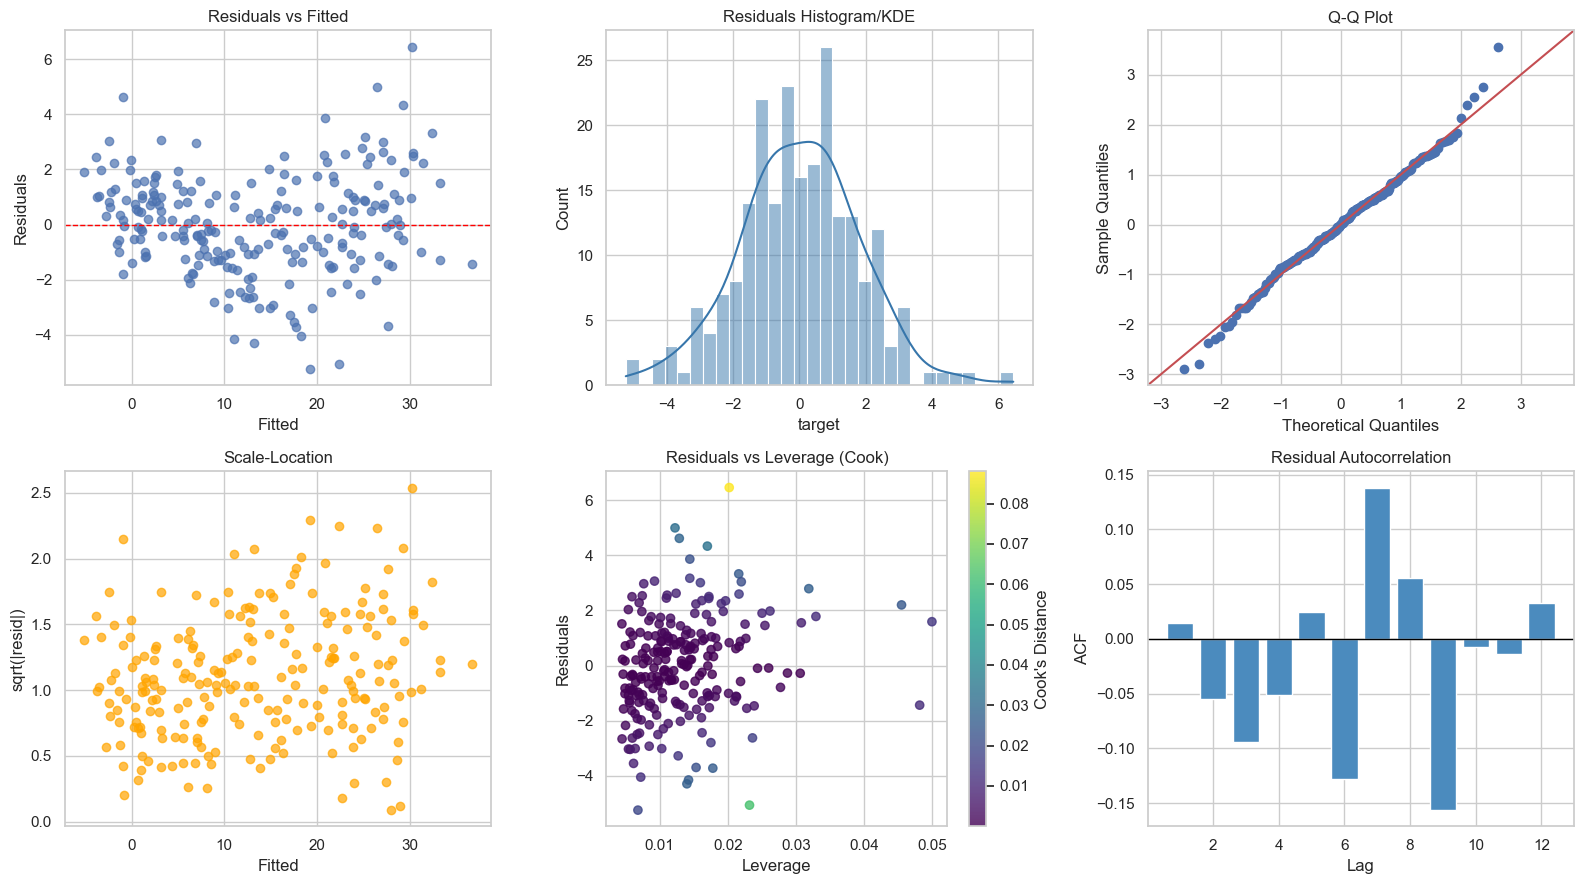

Leverage summary -> min: 0.0045  max: 0.0499  mean: 0.0133
Top 5 Cook's distance:
99     0.087997
241    0.062490
264    0.033105
166    0.031418
258    0.028232
dtype: float64


In [8]:
# 7. Residual Diagnostic Plots
# (Rewritten with defensive checks to avoid long blocking ops.)
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.ravel()

# Ensure needed arrays exist
assert 'train_pred' in globals() and 'train_resid' in globals(), 'Prerequisite variables missing.'

resid_series = pd.Series(train_resid)

# (1) Residuals vs Fitted
axes[0].scatter(train_pred, train_resid, alpha=0.7)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted')
axes[0].set_ylabel('Residuals')

# (2) Histogram + KDE
sns.histplot(train_resid, kde=True, ax=axes[1], bins=30, color='#3776ab')
axes[1].set_title('Residuals Histogram/KDE')

# (3) Q-Q Plot
sm.ProbPlot(train_resid, fit=True).qqplot(line='45', ax=axes[2])
axes[2].set_title('Q-Q Plot')

# (4) Scale-Location (Spread vs Fitted)
axes[3].scatter(train_pred, np.sqrt(np.abs(train_resid)), alpha=0.7, color='orange')
axes[3].set_title('Scale-Location')
axes[3].set_xlabel('Fitted')
axes[3].set_ylabel('sqrt(|resid|)')

# (5) Leverage vs Residuals (Cook's distance coloring)
X_train_sm2 = sm.add_constant(X_train, has_constant='add')
ols_full = sm.OLS(y_train, X_train_sm2).fit()
influence = OLSInfluence(ols_full)
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]
sc = axes[4].scatter(leverage, train_resid, c=cooks, cmap='viridis', alpha=0.8)
axes[4].set_title('Residuals vs Leverage (Cook)')
axes[4].set_xlabel('Leverage')
axes[4].set_ylabel('Residuals')
cb = fig.colorbar(sc, ax=axes[4])
cb.set_label("Cook's Distance")

# (6) Autocorrelation (simple bar plot up to lag 12)
max_lag = 12
ac_vals = [resid_series.autocorr(lag=i) for i in range(1, max_lag+1)]
axes[5].bar(range(1, max_lag+1), ac_vals, color='#4b8bbe')
axes[5].axhline(0, color='black', linewidth=1)
axes[5].set_title('Residual Autocorrelation')
axes[5].set_xlabel('Lag')
axes[5].set_ylabel('ACF')

plt.tight_layout()
plt.show()

print('Leverage summary -> min: %.4f  max: %.4f  mean: %.4f' % (leverage.min(), leverage.max(), leverage.mean()))
print("Top 5 Cook's distance:")
print(pd.Series(cooks).sort_values(ascending=False).head())

### 8. Interpreting Diagnostic Plots

1. Residuals vs Fitted: We look for a random cloud around zero. Visible funnel shapes or curves imply heteroskedasticity or non-linearity. Here, mild patterning may stem from injected non-linearity.
2. Histogram/KDE: Should approximate normal for well-behaved errors. Long tails or skewness suggest transformation or robust methods.
3. Q-Q Plot: Points should lie near the 45° line. Systematic S-shape indicates heavy/light tails vs normal.
4. Scale-Location: Flat horizontal band indicates constant variance. Trend upward = increasing variance (heteroskedasticity).
5. Residuals vs Leverage (Cook's): Points with high leverage and large residual influence model disproportionately. Cook's distance color highlights potential influential observations.
6. Autocorrelation: Bars near zero (within approximate ±2/sqrt(n) bounds) suggest independence. Patterned decay implies temporal structure or missing dynamics.


In [9]:
# 9. Statistical Tests for Assumptions
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson

# Normality: Jarque-Bera
jb_stat, jb_pvalue, jb_skew, jb_kurt = jarque_bera(train_resid)
# Shapiro-Wilk (scipy) - good for smaller samples (<5000)
shapiro_stat, shapiro_pvalue = stats.shapiro(train_resid)

# Heteroskedasticity: Breusch-Pagan
bp_stat, bp_pvalue, f_stat, f_pvalue = het_breuschpagan(train_resid, X_train_sm2)

# Autocorrelation: Durbin-Watson
# (2 ~ no autocorr, <1 or >3 problematic)
dw = durbin_watson(train_resid)

# Autocorrelation across lags: Ljung-Box (up to lag 10)
ljung = acorr_ljungbox(train_resid, lags=[10], return_df=True)
lj_stat = ljung['lb_stat'].iloc[0]
lj_pvalue = ljung['lb_pvalue'].iloc[0]

print('Jarque-Bera: stat=%.4f p=%.4g (Skew=%.3f Kurt(excess)=%.3f)' % (jb_stat, jb_pvalue, jb_skew, jb_kurt-3))
print('Shapiro-Wilk: stat=%.4f p=%.4g' % (shapiro_stat, shapiro_pvalue))
print('Breusch-Pagan: stat=%.4f p=%.4g  (F=%.4f F_p=%.4g)' % (bp_stat, bp_pvalue, f_stat, f_pvalue))
print('Durbin-Watson: %.4f' % dw)
print('Ljung-Box (lag=10): stat=%.4f p=%.4g' % (lj_stat, lj_pvalue))

assumption_results = pd.DataFrame({
    'Test': ['Jarque-Bera','Shapiro-Wilk','Breusch-Pagan','Durbin-Watson','Ljung-Box (10)'],
    'Statistic': [jb_stat, shapiro_stat, bp_stat, dw, lj_stat],
    'p_value': [jb_pvalue, shapiro_pvalue, bp_pvalue, np.nan, lj_pvalue]
})
assumption_results

Jarque-Bera: stat=3.5714 p=0.1677 (Skew=0.039 Kurt(excess)=0.612)
Shapiro-Wilk: stat=0.9938 p=0.4755
Breusch-Pagan: stat=13.1472 p=0.001397  (F=6.8885 F_p=0.001252)
Durbin-Watson: 1.9636
Ljung-Box (lag=10): stat=17.8827 p=0.05697


,Test,Statistic,p_value
0,Jarque-Bera,3.571395,0.167680
1,Shapiro-Wilk,0.993789,0.475471
2,Breusch-Pagan,13.147243,0.001397
3,Durbin-Watson,1.963629,NaN
4,Ljung-Box (10),17.882743,0.056974


In [11]:
# 10. Multicollinearity: Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure we have a DataFrame version of scaled features used for training
y_train_index = y_train.index if isinstance(y_train, pd.Series) else None
X_train_df = pd.DataFrame(X_train, columns=['feature_x1','feature_x2'])

vif_data = []
for i, col in enumerate(X_train_df.columns):
    vif = variance_inflation_factor(X_train_df.values, i)
    vif_data.append({'feature': col, 'VIF': vif})

vif_df = pd.DataFrame(vif_data)
print(vif_df)

# Rule of thumb: VIF > 5 (or >10) indicates problematic multicollinearity.
vif_df

      feature       VIF
0  feature_x1  1.000094
1  feature_x2  1.000094


,feature,VIF
0,feature_x1,1.000094
1,feature_x2,1.000094


In [12]:
# 11. Interactive Refit & Diagnostics
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.linear_model import LinearRegression, Ridge, Lasso

feature_options = ['feature_x1','feature_x2']
model_type = widgets.ToggleButtons(options=['Linear','Ridge','Lasso'], description='Model:')
alpha_slider = widgets.FloatLogSlider(value=1.0, base=10, min=-3, max=2, step=0.1, description='alpha')
feature_select = widgets.SelectMultiple(options=feature_options, value=tuple(feature_options), description='Features')
run_button = widgets.Button(description='Refit & Plot', button_style='primary', icon='refresh')
output_area = widgets.Output()

def run_refit(_):
    with output_area:
        clear_output(wait=True)
        chosen = list(feature_select.value)
        if not chosen:
            print('Select at least one feature.')
            return
        X_sub = pd.DataFrame(X_train, columns=feature_options)[chosen].values
        X_sub_test = pd.DataFrame(X_test, columns=feature_options)[chosen].values
        mtype = model_type.value
        if mtype == 'Linear':
            mdl = LinearRegression()
        elif mtype == 'Ridge':
            mdl = Ridge(alpha=alpha_slider.value)
        else:
            mdl = Lasso(alpha=alpha_slider.value, max_iter=5000)
        mdl.fit(X_sub, y_train)
        pred_tr = mdl.predict(X_sub)
        pred_te = mdl.predict(X_sub_test)
        resid_tr = y_train - pred_tr
        print(f'Model: {mtype} | Features: {chosen} | Train R2={r2_score(y_train, pred_tr):.4f} Test R2={r2_score(y_test, pred_te):.4f}')
        fig, ax = plt.subplots(1, 2, figsize=(12,4))
        ax[0].scatter(pred_tr, resid_tr, alpha=0.7)
        ax[0].axhline(0, color='red', linestyle='--')
        ax[0].set_title('Residuals vs Fitted')
        sns.histplot(resid_tr, kde=True, ax=ax[1], bins=25)
        ax[1].set_title('Residuals Histogram')
        plt.tight_layout()
        plt.show()

run_button.on_click(run_refit)

controls = widgets.VBox([
    model_type,
    alpha_slider,
    feature_select,
    run_button
])

display(widgets.HBox([controls, output_area]))

In [14]:
# 12. Figure Saving Utility
from datetime import datetime
from pathlib import Path

# Re-establish BASE_DIR if not in namespace (kernel restarts etc.)
if 'BASE_DIR' not in globals():
    BASE_DIR = Path.cwd()

reports_dir = BASE_DIR / 'reports'
reports_dir.mkdir(exist_ok=True)

def save_current_figures(prefix='diagnostics'):
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    for i, num in enumerate(plt.get_fignums(), start=1):
        fig = plt.figure(num)
        out_path = reports_dir / f"{prefix}_{ts}_{i}.png"
        fig.savefig(out_path, dpi=150, bbox_inches='tight')
        print('Saved', out_path)

print('Call save_current_figures() after generating plots to export them.')

Call save_current_figures() after generating plots to export them.


In [15]:
# 13. Export Residuals with Leverage & Cook's Distance
# Recompute leverage & Cook's distance on full training design if not present
if 'influence' not in globals():
    X_train_sm2 = sm.add_constant(X_train, has_constant='add')
    ols_full = sm.OLS(y_train, X_train_sm2).fit()
    influence = OLSInfluence(ols_full)

residuals_enriched = residuals_df.copy()
residuals_enriched['leverage'] = influence.hat_matrix_diag
residuals_enriched['cooks_distance'] = influence.cooks_distance[0]

export_dir = BASE_DIR / 'exports'
export_dir.mkdir(exist_ok=True)

csv_path = export_dir / 'linear_regression_residuals.csv'
parquet_path = export_dir / 'linear_regression_residuals.parquet'
residuals_enriched.to_csv(csv_path, index=False)
try:
    residuals_enriched.to_parquet(parquet_path, index=False)
    parquet_written = True
except Exception as e:
    print('Parquet export skipped:', e)
    parquet_written = False

print('CSV exported ->', csv_path)
if parquet_written:
    print('Parquet exported ->', parquet_path)
residuals_enriched.head()

Parquet export skipped: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
CSV exported -> d:\Python Project\MachineLearning\BismayaSite1\notebooks\exports\linear_regression_residuals.csv


,fitted_train,resid_train,leverage,cooks_distance
107,6.496931,-1.746645,0.006392,0.001983
5,36.728237,-1.435975,0.048150,0.011000
207,19.397413,-0.531980,0.011774,0.000342
277,13.611126,0.435657,0.007482,0.000145
259,20.167652,0.635859,0.009738,0.000403
